# Degeneracy analysis

__Définition:__ L'estimateur de Kraskov de l'entropie différentielle échoue lorsque les données possèdent des échantillons identiques ou très proches i.e. des diracs dans la densité de probabilité. Ces valeurs sont dites dégénérées.

__Objectifs:__
* Illustrer le phénomène de dégénérescence dans le calcul de l'entropie différentielle par l'estimateur de Kraskov.
* Etudier l'impact d'un bruit additif gaussien sur la valeur de l'entropie et sur les dégénérescences.
* Identifier les potentielles dégénérescences dans les paramètres physiques.
* Estimer une valeur adéquate pour l'écart type du bruit additif gaussien pour résoudre ces dégénérescences.

In [2]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(), "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from infovar.stats import entropy_estimators as ee

base = 2

## Analytical example

In [2]:
def degenerate(data: np.ndarray, frac: float) -> np.ndarray:
    """Returns a modified version of the array`data` with a fraction `frac` of duplicated elements. For instance, if `frac=0.5`, half of the array values are duplicates."""
    
    n = data.shape[0]
    m = round(frac * n)

    idx = np.arange(n)

    if frac > 1 or frac < 0:
        raise ValueError("frac must be within the interval [0, 1]")
    if m == 0:
        return data
    if m >= n-1:
        i = np.random.choice(idx, 1)
        return np.zeros_like(data) + data[i]

    idx_to_change = np.random.choice(idx, m, replace=False)
    idx_to_keep = idx[~np.isin(idx, idx_to_change)]
    
    new_data = data.copy()
    new_data[idx_to_change] = data[np.random.choice(idx_to_keep, m)]
    return new_data

def entropy_normal(sigma: float, base: float=2):
    return 0.5 * np.log(2*np.pi*np.e*sigma**2) / np.log(base)

### Data

In [3]:
n_samples = 100_000
sigma = 0.1

data = np.random.normal(0, sigma, n_samples)
data = data.reshape(-1, 1)

### Influence of the fraction of duplicates

In [4]:
fracs = np.linspace(0, 1, 200)

hs_degen = np.zeros_like(fracs)
for i, frac in enumerate(tqdm(fracs)):
    data_degen = degenerate(data, frac)
    hs_degen[i] = ee.entropy(data_degen, base=base)

h = ee.entropy(data, base=base)
href = entropy_normal(sigma, base=base)

100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


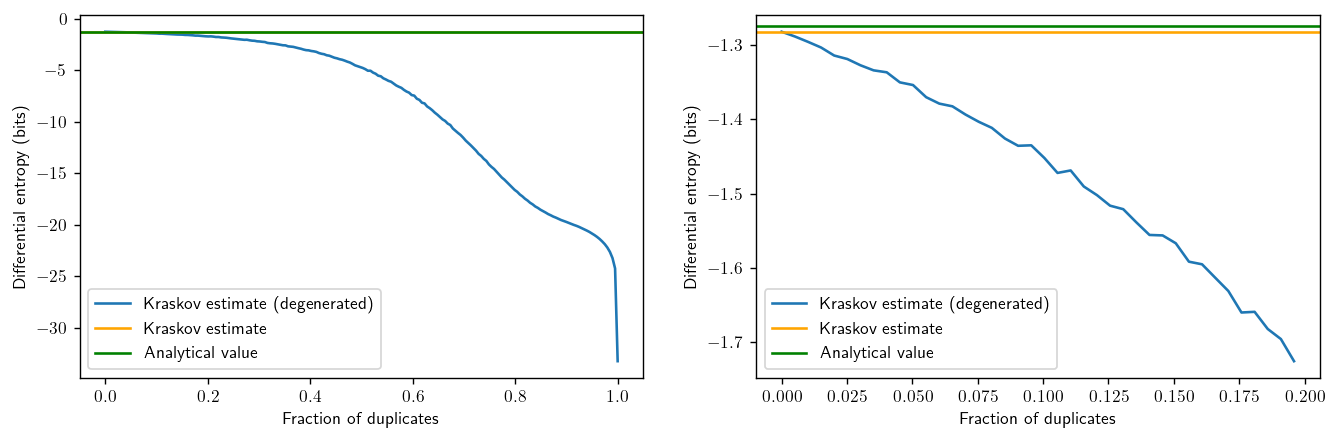

In [5]:
plt.figure(figsize=(2*6.4, 0.8*4.8), dpi=125)

plt.subplot(1, 2, 1)

plt.plot(fracs, hs_degen, label='Kraskov estimate (degenerated)')
plt.axhline(h, color='orange', label='Kraskov estimate')
plt.axhline(href, color='green', label='Analytical value')

plt.xlabel('Fraction of duplicates')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.subplot(1, 2, 2)

filt = fracs < 0.2
plt.plot(fracs[filt], hs_degen[filt], label='Kraskov estimate (degenerated)')
plt.axhline(h, color='orange', label='Kraskov estimate')
plt.axhline(href, color='green', label='Analytical value')

plt.xlabel('Fraction of duplicates')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.show()

### Impact of an additive Gaussian noise on degeneracy

In [6]:
fracs = [0.01, 0.1, 0.2, 0.5]
stds = np.logspace(-6, 1, 200)

hs_degen_list = []
for frac in fracs:
    hs_degen = np.zeros_like(stds)
    for i, std in enumerate(tqdm(stds)):
        data_degen = degenerate(data, frac)
        data_degen += np.random.normal(0, std, data.shape)
        hs_degen[i] = entropy(data_degen, base=base)
    hs_degen_list.append(hs_degen)

h = entropy(data, base=base)
href = entropy_normal(sigma, base=base)

100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


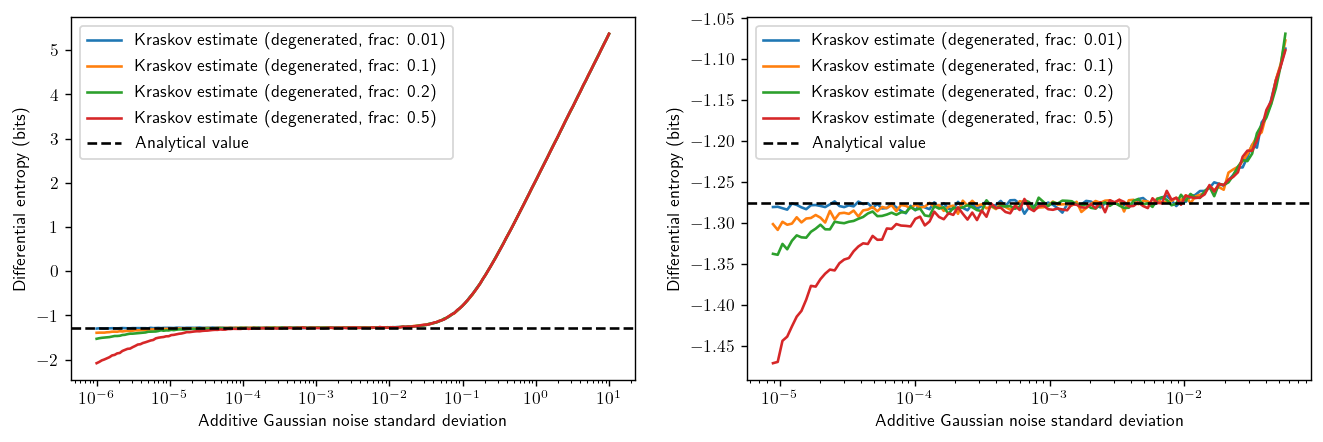

In [7]:
plt.figure(figsize=(2*6.4, 0.8*4.8), dpi=125)

plt.subplot(1, 2, 1)

for frac, hs_degen in zip(fracs, hs_degen_list):
    plt.semilogx(stds, hs_degen, label=f'Kraskov estimate (degenerated, frac: {frac})')
plt.axhline(href, color='black', linestyle='--', label='Analytical value')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.subplot(1, 2, 2)

filt = np.abs(hs_degen - href) < 0.2
for frac, hs_degen in zip(fracs, hs_degen_list):
    plt.semilogx(stds[filt], hs_degen[filt], label=f'Kraskov estimate (degenerated, frac: {frac})')
plt.axhline(href, color='black', linestyle='--', label='Analytical value')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.show()

## Californian housing example

The Californian housing dataset is an interesting example because some features are composed of discrete values (for instance, integers).

In [ ]:
# TODO